<a href="https://colab.research.google.com/github/DattaIn/idatta.github.io/blob/master/Stock_Trading_using_DRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to

* perform stock trading using Deep Reinforcement Learning
* build an environment for agent and perform stock trading
* experiment with SAC model and improve the reward
* create a dashboard for stock trading using `jupyter-dash`

## Information

Deep reinforcement learning combines artificial neural networks with a framework of reinforcement learning that helps software agents learn how to reach their goals. That is, it unites function approximation and target optimization, mapping states and actions to the rewards they lead to.

Reinforcement learning refers to goal-oriented algorithms, which learn how to achieve a complex objective (goal) or how to maximize along a particular dimension over many steps; for example, they can maximize the points won in a game over many moves. Reinforcement learning algorithms can start from a blank slate, and under the right conditions, achieve superhuman performance. Like a pet incentivized by scolding and treats, these algorithms are penalized when they make the wrong decisions and rewarded when they make the right ones – this is reinforcement.

![img](https://miro.medium.com/max/974/0*NgZ_bq_nUOq73jK_.png)

**SAC:** Soft Actor Critic is defined for RL tasks involving continuous actions. The biggest feature of SAC is that it uses a modified RL objective function. Instead of only seeking to maximize the lifetime rewards, SAC seeks to also maximize the entropy of the policy. The term ‘entropy’ has a rather esoteric definition and many interpretations depending on the application

![img](https://miro.medium.com/max/353/0*5Y3SzMyOQZBRUhrh.png)

Fig: Actor-Critic architecture. Source: Medium

Learning of the actor is based policy gradient approach and critic is learned in value-based fashion. In SAC, there are three networks: the first network represents state-value(V) parameterised by ψ, the second one is a policy function that parameterised by ϕ, and the last one represents soft q function parameterised by θ.

Read More about SAC [here](https://arxiv.org/abs/1801.01290)

## Dataset

### Dataset Description

The Dataset chosen for this mini project is NIFTY50 Stock tradings. The data is the price history and trading volumes of the fifty stocks in the index NIFTY 50 from NSE (National Stock Exchange) India. All stocks are at a day-level with pricing and trading values split across. The NIFTY 50 is a diversified 50 stock index accounting for 13 sectors of the economy.

See the stock indexes of NIFTY 50 in the following [link](https://www1.nseindia.com/products/content/equities/indices/nifty_50.htm)

**Note:** Choose the NIFTY 50 ticker symbols and download the stock data from '2009-01-01' to '2021-09-01' using YahooDownloader

In [ ]:
#@title Install FinRL
!pip -qq install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

     |████████████████████████████████| 161 kB 51.6 MB/s 
     |████████████████████████████████| 49.6 MB 7.9 kB/s 
     |████████████████████████████████| 1.8 MB 52.5 MB/s 
     |████████████████████████████████| 124 kB 71.1 MB/s 
     |████████████████████████████████| 108 kB 66.6 MB/s 
     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 2.0 MB 41.3 MB/s 
     |████████████████████████████████| 153 kB 63.2 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 103 kB 57.8 MB/s 
     |████████████████████████████████| 636 kB 59.3 MB/s 
     |████████████████████████████████| 1.3 MB 42.7 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 294 kB 71.8 MB/s 
     |████████████████████████████████| 142 kB 76.2 MB/s 
     |████████████████████████████████| 3.0 MB 43.7 MB/s 
     |████████████████████████████████| 291 kB 58.2 MB/s 
     |██████████████

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/nifty50list.csv

### Import required packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import warnings
warnings.filterwarnings("ignore")
import datetime
import os
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import sys
sys.path.append("../FinRL-Library")

from math import sqrt

### Data Loading (1 point)

* Read the ticker symbols of Nifty 50 and add `.NS` extension

* Using the symbols download the stock prices data using YahooDownloader

Hint: [YahooDownloader](https://gist.githubusercontent.com/BruceYanghy/6c37022257cfe765d551c1b173570bd4/raw/b2c69214c6316ff8fa46d9b14d437ec6a1edeef2/DownloadData.py)

In [ ]:
path = "/content/nifty50list.csv"
# YOUR CODE HERE
nifty = pd.read_csv(path)
nifty.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,ACC Ltd.,CEMENT & CEMENT PRODUCTS,ACC,EQ,INE012A01025
1,Abbott India Ltd.,PHARMA,ABBOTINDIA,EQ,INE358A01014
2,Adani Enterprises Ltd.,METALS,ADANIENT,EQ,INE423A01024
3,Adani Green Energy Ltd.,POWER,ADANIGREEN,EQ,INE364U01010
4,Adani Transmission Ltd.,POWER,ADANITRANS,EQ,INE931S01010


In [ ]:
nifty['Yahoo_Code'] = nifty.Symbol + '.NS'
nifty.head()

,Company Name,Industry,Symbol,Series,ISIN Code,Yahoo_Code
0,ACC Ltd.,CEMENT & CEMENT PRODUCTS,ACC,EQ,INE012A01025,ACC.NS
1,Abbott India Ltd.,PHARMA,ABBOTINDIA,EQ,INE358A01014,ABBOTINDIA.NS
2,Adani Enterprises Ltd.,METALS,ADANIENT,EQ,INE423A01024,ADANIENT.NS
3,Adani Green Energy Ltd.,POWER,ADANIGREEN,EQ,INE364U01010,ADANIGREEN.NS
4,Adani Transmission Ltd.,POWER,ADANITRANS,EQ,INE931S01010,ADANITRANS.NS


In [ ]:
""" Download and save the data in a pandas DataFrame """

start_date = '2009-01-01'
end_date = '2021-09-01'
# YahooDownloader?
# YOUR CODE HERE
df = YahooDownloader(start_date, end_date, ticker_list = nifty.Yahoo_Code).fetch_data()
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,date,open,high,low,close,volume,tic,day
0,2009-01-02,280.100006,280.100006,280.100006,236.199570,0.0,ABBOTINDIA.NS,4
1,2009-01-02,503.899994,503.899994,484.000000,385.829071,515098.0,ACC.NS,4
2,2009-01-02,24.524010,25.206083,23.987547,19.948500,527417.0,ADANIENT.NS,4
3,2009-01-02,71.750000,72.000000,67.849998,52.157703,2316342.0,AMBUJACEM.NS,4
4,2009-01-02,223.500000,244.875000,219.500000,223.279022,117614.0,APOLLOHOSP.NS,4


### Preprocess Data (1 point)

FinRL uses a `FeatureEngineer` class to preprocess data. Some of the technical indicators to be used in the analysis of financial markets includes.

1. `relative strength index` (RSI): it represents the size of recent gains and losses, during a specified time period.
2. `moving average convergence divergence` (MACD):  it is an indicator to determine price momentum and short term trend.
3. `commodity channel index` (CCI): its an indicator helps in identifying cyclical trends.
4. `directional index` (DX): it represents group of directional movements that form trading system

* Configure the technical indicators and apply feature engineering

  Hint: `FeatureEngineer()`

In [ ]:
""" Perform Feature Engineering """
# YOUR CODE HERE
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
print(tech_indicator_list)

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)
df.head()

['macd', 'rsi_30', 'cci_30', 'dx_30']
Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30
0,2009-01-02,503.899994,503.899994,484.000000,385.829071,515098.0,ACC.NS,4,0.0,100.0,66.666667,100.0
3113,2009-01-02,24.524010,25.206083,23.987547,19.948500,527417.0,ADANIENT.NS,4,0.0,100.0,66.666667,100.0
6226,2009-01-02,71.750000,72.000000,67.849998,52.157703,2316342.0,AMBUJACEM.NS,4,0.0,100.0,66.666667,100.0
9339,2009-01-02,223.500000,244.875000,219.500000,223.279022,117614.0,APOLLOHOSP.NS,4,0.0,100.0,66.666667,100.0
12452,2009-01-02,17.000000,17.590000,16.750000,15.529279,874800.0,AUROPHARMA.NS,4,0.0,100.0,66.666667,100.0


### Exploratory Data Analysis (2 points)

#### Describe the statistics of the data

In [ ]:
# YOUR CODE HERE
df.describe()

,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30
count,99616.000000,99616.000000,99616.000000,99616.000000,9.961600e+04,99616.000000,99616.000000,99616.000000,99616.000000,99616.000000
mean,2206.754734,2235.675045,2176.366549,2138.931666,4.135475e+06,1.993254,9.572286,52.679860,20.048484,24.876923
std,8244.819467,8341.268036,8139.053374,8169.565743,1.814436e+07,1.410907,166.654931,8.726150,113.632097,17.710665
min,8.600000,8.600000,5.650000,7.416604,0.000000e+00,0.000000,-3582.119308,0.000000,-741.207923,0.000184
25%,129.899994,132.000000,127.679167,108.422297,1.880512e+05,1.000000,-1.783015,47.043373,-66.447481,10.442426
50%,324.299988,329.183334,319.200012,296.169296,9.181940e+05,2.000000,0.901365,52.725251,29.356271,21.795231
75%,926.788544,942.000000,911.062485,867.709717,3.059140e+06,3.000000,6.135385,58.464176,101.504167,36.264598
max,96770.000000,98599.953125,92750.000000,96910.757812,1.057367e+09,4.000000,4312.389095,100.000000,732.103509,100.000000


Clearly simple statistics do not provide meaningful insights into the data.

In [ ]:
closing = pd.pivot_table(df, index='date', columns='tic', values='close', aggfunc='sum')
start_prices = closing.head(1)
rebase_closing = 100 * closing.div(start_prices.iloc[0])
rebase_closing.head()

tic,ACC.NS,ADANIENT.NS,AMBUJACEM.NS,APOLLOHOSP.NS,AUROPHARMA.NS,BAJAJHLDNG.NS,BERGEPAINT.NS,BIOCON.NS,BOSCHLTD.NS,CADILAHC.NS,COLPAL.NS,DABUR.NS,GAIL.NS,GODREJCP.NS,HAVELLS.NS,HINDPETRO.NS,IGL.NS,LUPIN.NS,MARICO.NS,MCDOWELL-N.NS,MRF.NS,NAUKRI.NS,NMDC.NS,PEL.NS,PETRONET.NS,PGHH.NS,PIDILITIND.NS,PNB.NS,SIEMENS.NS,UBL.NS,VEDL.NS,YESBANK.NS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2009-01-05,102.763721,110.009419,101.447191,97.637877,101.046186,103.222621,103.550303,100.522717,100.105608,98.119661,99.314014,99.764572,103.082085,99.009534,105.963841,99.435670,107.521690,96.225836,97.256867,103.307075,100.771304,99.867169,99.470187,100.983692,103.143887,99.929463,100.408512,100.685894,100.997666,102.946834,104.128164,108.415240
2009-01-06,110.032369,112.610320,110.564397,96.701359,102.092390,104.290252,103.550303,103.498205,99.153483,97.618224,97.464480,101.471457,101.565117,100.565955,108.541740,100.733622,101.446478,93.463698,99.418131,106.342648,99.517649,98.743965,97.827799,99.120979,101.088271,98.095791,98.774403,99.680533,103.874283,103.331199,102.987510,107.678149
2009-01-07,102.986440,108.338571,104.486262,95.296571,91.107203,98.398591,102.514798,93.445909,98.817149,96.919804,94.402228,103.119505,95.665758,90.272384,101.654469,99.680201,102.507237,89.035165,92.518709,98.723865,92.524502,97.922716,84.847667,97.886151,89.842824,91.665070,98.547435,91.759851,99.135332,98.014098,95.274294,96.683053
2009-01-09,101.994345,99.274885,105.137518,91.040589,90.409754,95.413217,103.550303,97.265766,98.212758,97.761488,95.884354,103.766963,97.543935,90.519976,99.268926,100.714842,105.978782,88.198152,88.362427,84.990490,89.662095,99.106287,78.384090,96.253677,87.424438,92.979416,98.502026,91.261865,86.863972,93.657910,88.104291,93.243233


In [ ]:
rebase_closing.describe()

tic,ACC.NS,ADANIENT.NS,AMBUJACEM.NS,APOLLOHOSP.NS,AUROPHARMA.NS,BAJAJHLDNG.NS,BERGEPAINT.NS,BIOCON.NS,BOSCHLTD.NS,CADILAHC.NS,COLPAL.NS,DABUR.NS,GAIL.NS,GODREJCP.NS,HAVELLS.NS,HINDPETRO.NS,IGL.NS,LUPIN.NS,MARICO.NS,MCDOWELL-N.NS,MRF.NS,NAUKRI.NS,NMDC.NS,PEL.NS,PETRONET.NS,PGHH.NS,PIDILITIND.NS,PNB.NS,SIEMENS.NS,UBL.NS,VEDL.NS,YESBANK.NS
count,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000
mean,312.402818,689.172730,333.279642,483.629240,2754.118002,857.593341,1899.908352,803.662413,460.348275,788.336421,505.745806,670.018137,242.329324,952.546587,2941.701697,393.934901,962.524829,707.544426,751.747776,244.380711,1833.831521,1150.546155,106.660682,611.184813,768.758072,845.021574,1271.872497,139.649903,357.860347,1025.800991,267.403856,802.251352
std,91.212910,1289.937994,117.784669,310.639281,2026.992048,575.397161,1915.798767,687.959276,227.738660,428.993686,252.686897,417.432584,69.914285,604.667387,2518.068501,282.466236,873.606318,374.676734,505.055921,99.807258,1354.940458,1242.645728,38.501119,458.637743,503.548444,574.540189,1094.657864,59.805968,145.886179,472.678701,100.416549,680.256919
min,96.072087,76.686617,94.230038,73.923006,75.730293,84.381176,96.153859,79.051064,94.090680,85.136120,93.593828,99.764572,90.849964,80.160899,81.646787,71.139747,93.587257,85.481659,88.362427,52.028231,75.501962,97.222215,51.235320,72.059455,77.629994,87.362957,74.398542,29.953642,63.377578,89.686106,74.307434,51.105643
25%,246.381484,201.320233,252.816678,262.788743,553.770612,357.239718,336.155559,261.721705,257.584233,420.412742,284.270173,265.432586,192.179938,333.566992,836.873206,132.538420,294.469219,392.510104,277.146564,145.277363,485.377297,331.018849,82.038613,212.773174,342.221003,288.196534,310.706670,89.917226,240.696989,651.215929,202.356556,327.202133
50%,321.410233,339.421952,346.301384,480.604756,3261.871810,683.715758,1353.859450,404.865292,468.390980,774.269426,512.893874,651.798364,223.492256,860.907280,2251.505134,292.636811,480.015397,676.383826,694.528999,271.509657,1735.392489,783.008652,95.268068,453.329473,508.627598,819.989967,1061.638486,151.398730,352.784315,1036.900341,247.315760,475.829690
75%,373.825895,559.639858,395.686540,588.896326,4616.473834,1407.632972,2581.726518,1433.700059,663.488601,1112.344406,668.225948,995.411283,286.139023,1529.837353,4640.553501,629.005905,1605.355360,914.030944,1175.974642,321.605471,3165.035652,1359.015609,116.310300,970.630250,1287.640313,1402.362168,2083.877925,183.449631,453.942106,1349.459091,332.878093,1118.413106
max,630.616063,8521.050117,809.468180,2225.712812,6733.741821,2340.216144,7990.688098,2587.518711,944.647728,2050.889901,1145.323671,1700.502012,416.075993,2624.790049,11088.036346,1130.415027,3285.323267,1683.456919,2123.017365,433.920432,4916.796021,6216.409164,299.333762,1733.853923,1727.735878,2135.237511,4638.721885,274.679356,849.775465,1949.021209,594.441132,2642.359933


In [ ]:
log_returns = np.log(rebase_closing).diff(1)
log_returns = log_returns.dropna()
log_returns

tic,ACC.NS,ADANIENT.NS,AMBUJACEM.NS,APOLLOHOSP.NS,AUROPHARMA.NS,BAJAJHLDNG.NS,BERGEPAINT.NS,BIOCON.NS,BOSCHLTD.NS,CADILAHC.NS,COLPAL.NS,DABUR.NS,GAIL.NS,GODREJCP.NS,HAVELLS.NS,HINDPETRO.NS,IGL.NS,LUPIN.NS,MARICO.NS,MCDOWELL-N.NS,MRF.NS,NAUKRI.NS,NMDC.NS,PEL.NS,PETRONET.NS,PGHH.NS,PIDILITIND.NS,PNB.NS,SIEMENS.NS,UBL.NS,VEDL.NS,YESBANK.NS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-05,0.027262,0.095396,0.014368,-0.023905,0.010408,0.031718,0.034887,0.005214,0.001056,-0.018982,-0.006883,-0.002357,0.030355,-0.009954,0.057928,-0.005659,0.072522,-0.038472,-0.027815,0.032536,0.007683,-0.001329,-0.005312,0.009789,0.030955,-0.000706,0.004077,0.006836,0.009927,0.029042,0.040452,0.080798
2009-01-06,0.068342,0.023367,0.086060,-0.009638,0.010300,0.010290,0.000000,0.029171,-0.009557,-0.005124,-0.018799,0.016964,-0.014825,0.015598,0.024037,0.012969,-0.058161,-0.029125,0.021979,0.028961,-0.012519,-0.011311,-0.016649,-0.018618,-0.020131,-0.018520,-0.016408,-0.010035,0.028084,0.003727,-0.011015,-0.006822
2009-01-07,-0.066177,-0.038672,-0.056543,-0.014634,-0.113841,-0.058151,-0.010050,-0.102172,-0.003398,-0.007180,-0.031923,0.016111,-0.059840,-0.107982,-0.065555,-0.010513,0.010402,-0.048542,-0.071924,-0.074340,-0.072862,-0.008352,-0.142351,-0.012536,-0.117932,-0.067803,-0.002300,-0.082796,-0.046695,-0.052828,-0.077848,-0.107709
2009-01-09,-0.009680,-0.087369,0.006214,-0.045688,-0.007685,-0.030809,0.010050,0.040064,-0.006135,0.008647,0.015578,0.006259,0.019442,0.002739,-0.023747,0.010326,0.033306,-0.009445,-0.045964,-0.149787,-0.031425,0.012014,-0.079237,-0.016818,-0.027287,0.014237,-0.000461,-0.005442,-0.132143,-0.045462,-0.078239,-0.036227
2009-01-12,-0.015202,0.037246,-0.046487,0.029063,-0.025062,-0.025605,0.000000,-0.047406,0.002264,-0.050724,-0.024178,0.025204,0.017617,0.031541,-0.015232,-0.030725,-0.033306,-0.001814,0.007498,0.022991,-0.010239,0.004135,-0.006442,-0.046966,-0.016737,0.002273,-0.052993,-0.025548,-0.097648,0.004096,-0.055781,-0.016606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-25,-0.005980,0.025781,0.004291,-0.014378,0.012275,0.011574,-0.008188,-0.006747,-0.001315,-0.010807,0.005234,0.012155,-0.003789,0.026677,-0.049768,0.031918,0.000000,0.001063,-0.018085,-0.013367,-0.001847,0.006083,0.009646,-0.017765,-0.001533,0.006723,0.003030,0.002747,-0.004739,-0.015175,0.012664,-0.004556
2021-08-26,0.003610,0.000237,0.003269,-0.015045,0.003439,-0.005981,0.002610,-0.017874,-0.015799,-0.004430,-0.001510,0.008958,-0.015650,0.001728,0.008887,-0.009156,-0.000953,-0.003567,0.018851,0.001096,-0.005873,0.000103,-0.050536,0.001306,-0.002194,0.034697,0.005785,-0.017994,0.009817,0.002476,-0.008657,0.000000
2021-08-27,0.031385,0.020358,0.028948,0.013671,0.017619,0.012654,-0.000890,0.016577,-0.000414,0.018238,0.000725,0.005353,0.005941,0.010874,0.016327,0.004296,0.000858,0.002823,0.005444,0.023180,0.005067,0.016952,0.024274,0.001576,0.001098,0.010777,-0.001123,0.009729,0.005030,0.008910,0.017410,0.009091


In [ ]:
log_returns.describe()

tic,ACC.NS,ADANIENT.NS,AMBUJACEM.NS,APOLLOHOSP.NS,AUROPHARMA.NS,BAJAJHLDNG.NS,BERGEPAINT.NS,BIOCON.NS,BOSCHLTD.NS,CADILAHC.NS,COLPAL.NS,DABUR.NS,GAIL.NS,GODREJCP.NS,HAVELLS.NS,HINDPETRO.NS,IGL.NS,LUPIN.NS,MARICO.NS,MCDOWELL-N.NS,MRF.NS,NAUKRI.NS,NMDC.NS,PEL.NS,PETRONET.NS,PGHH.NS,PIDILITIND.NS,PNB.NS,SIEMENS.NS,UBL.NS,VEDL.NS,YESBANK.NS
count,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000
mean,0.000589,0.001406,0.000671,0.000997,0.001236,0.001013,0.001392,0.000950,0.000518,0.000916,0.000763,0.000911,0.000401,0.001050,0.001513,0.000685,0.001103,0.000665,0.000980,0.000439,0.001189,0.001327,0.000136,0.000871,0.000865,0.000983,0.001228,-0.000284,0.000688,0.000950,0.000539,-0.000095
std,0.018005,0.032665,0.020044,0.021634,0.026664,0.019718,0.021781,0.021719,0.017155,0.019720,0.014538,0.015768,0.019919,0.020618,0.023028,0.024876,0.021332,0.018782,0.017308,0.026575,0.020026,0.023176,0.024645,0.024761,0.020570,0.015145,0.017276,0.026030,0.021097,0.025974,0.029258,0.038569
min,-0.121909,-0.490194,-0.111657,-0.162396,-0.210340,-0.223127,-0.105038,-0.124567,-0.135502,-0.159653,-0.083854,-0.115072,-0.130165,-0.139647,-0.135454,-0.274037,-0.413939,-0.184906,-0.108500,-0.267517,-0.126679,-0.143182,-0.142351,-0.167751,-0.117932,-0.097081,-0.166537,-0.130378,-0.160577,-0.126747,-0.228595,-0.823578
25%,-0.009605,-0.013781,-0.010891,-0.010079,-0.012269,-0.007705,-0.010349,-0.010381,-0.008060,-0.009358,-0.007380,-0.008248,-0.010401,-0.010356,-0.010346,-0.012832,-0.009638,-0.009885,-0.008690,-0.013155,-0.009309,-0.011691,-0.012213,-0.010829,-0.010787,-0.006843,-0.008319,-0.013796,-0.010515,-0.011550,-0.015184,-0.014066
50%,-0.000084,0.000647,0.000509,0.000000,0.000280,0.000336,0.000376,0.000157,-0.000416,0.000081,0.000019,0.000749,0.000000,0.000496,0.000528,0.000235,0.000609,0.000584,0.000431,-0.000119,-0.000132,0.000000,0.000000,0.000189,0.000000,0.000000,0.000533,-0.000353,0.000442,-0.000175,0.000000,0.000000
75%,0.010537,0.016364,0.011825,0.011033,0.014569,0.009534,0.011821,0.011293,0.007804,0.010796,0.008030,0.009484,0.010870,0.012017,0.012406,0.013354,0.011280,0.010898,0.009657,0.013039,0.009564,0.011745,0.012002,0.012410,0.011400,0.007287,0.009100,0.013186,0.011558,0.011063,0.016446,0.014696
max,0.126885,0.241910,0.138617,0.197706,0.184600,0.194388,0.182628,0.144727,0.113282,0.180972,0.084832,0.110013,0.152090,0.197804,0.309051,0.162904,0.253553,0.126405,0.115221,0.298074,0.180716,0.161390,0.182520,0.182236,0.106510,0.139162,0.120680,0.379813,0.159572,0.182524,0.170393,0.457971


In [ ]:
mean_return = 250*log_returns.mean()
stdev = sqrt(250) * log_returns.std()
stock_summary = pd.concat([mean_return.rename('annual_return'), stdev.rename('ann_std_dev')], axis=1)
stock_summary.head()

,annual_return,ann_std_dev
tic,,
ACC.NS,0.147278,0.284684
ADANIENT.NS,0.351609,0.516472
AMBUJACEM.NS,0.167776,0.316922
APOLLOHOSP.NS,0.249250,0.342071
AUROPHARMA.NS,0.309014,0.421601


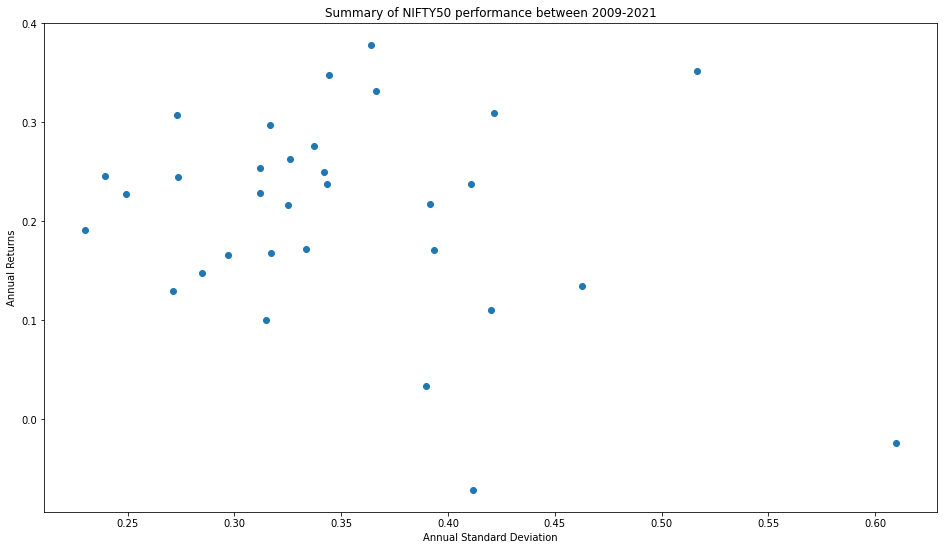

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,9))
plt.scatter(stock_summary['ann_std_dev'], stock_summary['annual_return'], marker='o')
plt.xlabel('Annual Standard Deviation')
plt.ylabel('Annual Returns')
plt.title('Summary of NIFTY50 performance between 2009-2021')
plt.show()

#### Find how many times did the stock prices end lower than their opening prices in 2019 vs in 2020?

**Hint:** Open - Close per day

In [ ]:
# YOUR CODE HERE

#### Find the stock that shows the highest increase in stock price per day, over the entire time period

In [ ]:
# YOUR CODE HERE

#### Find the loss percentage of each stock considering open and closing prices of each day

**Hint:** `sum(open - close) / len(instances)`

In [ ]:
# YOUR CODE HERE

#### Find the Top 10 Stocks with high volume

In [ ]:
# YOUR CODE HERE

In [ ]:
log_returns.head()

tic,ACC.NS,ADANIENT.NS,AMBUJACEM.NS,APOLLOHOSP.NS,AUROPHARMA.NS,BAJAJHLDNG.NS,BERGEPAINT.NS,BIOCON.NS,BOSCHLTD.NS,CADILAHC.NS,COLPAL.NS,DABUR.NS,GAIL.NS,GODREJCP.NS,HAVELLS.NS,HINDPETRO.NS,IGL.NS,LUPIN.NS,MARICO.NS,MCDOWELL-N.NS,MRF.NS,NAUKRI.NS,NMDC.NS,PEL.NS,PETRONET.NS,PGHH.NS,PIDILITIND.NS,PNB.NS,SIEMENS.NS,UBL.NS,VEDL.NS,YESBANK.NS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-05,0.027262,0.095396,0.014368,-0.023905,0.010408,0.031718,0.034887,0.005214,0.001056,-0.018982,-0.006883,-0.002357,0.030355,-0.009954,0.057928,-0.005659,0.072522,-0.038472,-0.027815,0.032536,0.007683,-0.001329,-0.005312,0.009789,0.030955,-0.000706,0.004077,0.006836,0.009927,0.029042,0.040452,0.080798
2009-01-06,0.068342,0.023367,0.086060,-0.009638,0.010300,0.010290,0.000000,0.029171,-0.009557,-0.005124,-0.018799,0.016964,-0.014825,0.015598,0.024037,0.012969,-0.058161,-0.029125,0.021979,0.028961,-0.012519,-0.011311,-0.016649,-0.018618,-0.020131,-0.018520,-0.016408,-0.010035,0.028084,0.003727,-0.011015,-0.006822
2009-01-07,-0.066177,-0.038672,-0.056543,-0.014634,-0.113841,-0.058151,-0.010050,-0.102172,-0.003398,-0.007180,-0.031923,0.016111,-0.059840,-0.107982,-0.065555,-0.010513,0.010402,-0.048542,-0.071924,-0.074340,-0.072862,-0.008352,-0.142351,-0.012536,-0.117932,-0.067803,-0.002300,-0.082796,-0.046695,-0.052828,-0.077848,-0.107709
2009-01-09,-0.009680,-0.087369,0.006214,-0.045688,-0.007685,-0.030809,0.010050,0.040064,-0.006135,0.008647,0.015578,0.006259,0.019442,0.002739,-0.023747,0.010326,0.033306,-0.009445,-0.045964,-0.149787,-0.031425,0.012014,-0.079237,-0.016818,-0.027287,0.014237,-0.000461,-0.005442,-0.132143,-0.045462,-0.078239,-0.036227
2009-01-12,-0.015202,0.037246,-0.046487,0.029063,-0.025062,-0.025605,0.000000,-0.047406,0.002264,-0.050724,-0.024178,0.025204,0.017617,0.031541,-0.015232,-0.030725,-0.033306,-0.001814,0.007498,0.022991,-0.010239,0.004135,-0.006442,-0.046966,-0.016737,0.002273,-0.052993,-0.025548,-0.097648,0.004096,-0.055781,-0.016606


#### Plot the closing value of stock with highest volume and returns

In [ ]:
# YOUR CODE HERE
%matplotlib inline
plt.figure(figsize=(16,9))
plt.scatter(stock_summary['ann_std_dev'], stock_summary['annual_return'], marker='o')
plt.xlabel('Annual Standard Deviation')
plt.ylabel('Annual Returns')
plt.title('Summary of NIFTY50 performance between 2009-2021')
plt.show()

#### Daily Returns of the stocks

* Apply pct_change() and extract daily returns

* Plot the histogram of daily returns

* Find the stock with maximum daily return

In [ ]:
# YOUR CODE HERE

### Train & Trade Data Split

In real life trading, the model needs to be updated periodically using rolling windows. Here, we just slice the data once into train and trade set.

In [ ]:
# YOUR CODE HERE
train_start_date, train_end_date = '2009-01-01', '2019-01-01'
trade_start_date, trade_end_date = train_end_date, '2021-09-01'
train = data_split(df, start = train_start_date, end = train_end_date)
trade = data_split(df, start = trade_start_date, end = trade_end_date)

### Build Environment (1 point)


* Define the below kwargs to be used in Stock Trading Environment

  * stock_dim: (int) number of unique stocks
  * hmax : (int) maximum number of shares to trade
  * initial_amount: (int) start money
  * transaction_cost_pct : (float) transaction cost percentage per trade
  * reward_scaling: (float) scaling factor for reward, good for training
  * tech_indicator_list: (list) a list of technical indicator names (modified from config.py)

In [ ]:
""" Build the stock trading Environment """
# YOUR CODE HERE
# Compute State Space and Action Space
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension
print(f"Stock data Dimensions: {stock_dimension}, State Spaces: {state_space}")

# Initialize an environment class
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock data Dimensions: 32, State Spaces: 193
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Implement DRL Algorithm (2 points)

Use Soft Actor-Critic (SAC) for stock trading, it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

* Define the SAC parameters and train the SAC model
* Optimize the parameters to improve the reward

In [ ]:
""" Train SAC Model """
# YOUR CODE HERE
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 200,
    "ent_coef": "auto_0.1"
}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=30000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 200, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac/sac_1


KeyboardInterrupt: ignored

#### Optional: Implement other DRL Algorithms

### Trading (1 point)

* Build the Environment for trading
* Use the trained SAC model to trade

In [ ]:
""" Create trading env and make prediction and get the account value change """
# YOUR CODE HERE
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Make prediction and get the account value change
df_account_value, df_actions = DRLAgent.DRL_prediction(model = trained_sac, environment = e_trade_gym)

In [ ]:
df_account_value.head()

### Backtesting Performance (Optional)

Backtesting plays a key role in evaluating the performance of a trading strategy. Backtesting assesses the viability of a trading strategy by discovering how it would perform on historical data. If backtesting works, traders and analysts may have increased confidence to employ it going forward.Automated backtesting tool is preferred because it reduces the human error.

`FinRL` uses a set of functions to do the backtesting with [Quantopian pyfolio](https://github.com/quantopian/pyfolio) package. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

* Perform backtest on the account values and baseline data

In [ ]:
""" BackTest Stats """
# YOUR CODE HERE
perf_stats_all = backtest_stats(account_value = df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

In [ ]:
baseline_df = get_baseline(ticker = '^NSEI',
                            start = trade_start_date,
                            end = trade_end_date)
stats = backtest_stats(baseline_df, value_col_name = 'close')

#### Plot the Backtest plot with baseline ticker as "^NSEI"

In [ ]:
""" BackTest Plot """
# YOUR CODE HERE
backtest_plot(account_value = df_account_value,     # pass the account value memory into the backtest functions
              baseline_ticker = '^NSEI',             # select a baseline ticker Dow Jones Index: ^DJI, S&P 500: ^GSPC, NASDAQ 100: ^NDX
              baseline_start = trade_start_date,
              baseline_end = trade_end_date)

### DashBoard (2 points)

Dash is a simple open source library. It is the original low-code framework for rapidly building data apps in Python, R, Julia, and F#. It can bind a user interface to Python code in less than 10 minutes.

Dash apps are rendered in the web browser. Since Dash apps are viewed in the web browser, Dash is inherently cross-platform and mobile ready.

Dash is released under the permissive MIT license. Plotly develops Dash and also offers a platform for writing and deploying Dash apps.

Refer to Dash Documentation [here](https://dash.plotly.com/). Mainly refer to Part 2 (Layout) and Part 3 (Basic callbacks) within the Dash tutorial in the given documentation.

To know more about Dash, refer [here](https://medium.com/plotly/introducing-jupyterdash-811f1f57c02e).



In [ ]:
# Install the library
!pip install -q jupyter-dash==0.3.0rc1 dash-bootstrap-components

#### Create the dashboard using Dash HTML components

Hint: [Layout](https://dash.plotly.com/layout) , [callbacks](https://dash.plotly.com/basic-callbacks)

* Scatter plot of Stock closing price
  * Create a dropdown for ticker Symbols
  * Create a plot of stock closing price values that changes upon selecting ticker using drop down
* Bar plot of trade off balance resulted from DRL Agent
  * Create two dropdowns for selecting start and end dates
  * Create a bar plot showing account value between start and end date as a result to dropdown change.


In [ ]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

In [ ]:
""" Build App """
app = JupyterDash(__name__)
# YOUR CODE HERE
app.layout = html.Div([
    html.H1("Stocks Dashboard using JupyterDash"),
    html.Label([
        "Ticker",
        dcc.Dropdown(
            id='tic-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in set(df.tic)
            ])
    ]),
    dcc.Graph(id='graph1')
])

# Define callback to update graph
@app.callback(
    Output('graph1', 'figure'),
    [Input("tic-dropdown", "value")]
)
def update_graph1(tic):
    df_ = df[df.tic == tic]
    return px.scatter(df_, x='date', y='close')

In [ ]:
# Run app and display result on external broswer
app.run_server(mode='external')

In [ ]:
app2 = JupyterDash(__name__)
app2.layout = html.Div([
    html.H1("Dashboard using JupyterDash"),
    html.Label([
        "startDate",
        dcc.Dropdown(
            id='startDate-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in df_account_value.date.values
            ])
    ]),
    html.Label([
        "endDate",
        dcc.Dropdown(
            id='endDate-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in df_account_value.date.values
            ])
    ]),
    dcc.Graph(id='graph2')
])

# Define callback to update graph
@app2.callback(
    Output('graph2', 'figure'),
    [Input("startDate-dropdown", "value"),Input("endDate-dropdown", "value")]
)
def update_graph2(startDate,endDate):
    required = df_account_value[(df_account_value.date > startDate) & (df_account_value.date < endDate)]
    return px.bar(required, x='date', y='account_value')

In [ ]:
app2.run_server(mode='external')

### Report Analysis

* Discuss on the parameters used to increase the reward
* Report the safest stocks to trade without much loss
* Comment on the Dashboard application and user interface
